In [27]:
from typing import *
import os
from glob import glob
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nptyping import NDArray
from IPython.display import display

sns.set_style('whitegrid')
colors = ['#de3838', '#007bc3', '#ffd12a']
markers = ['o', 'x', ',']
%config InlineBackend.figure_formats = ['svg']

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)

## バンデットアルゴリズム 

,estimate,mean
0,1.288688,1.267300
1,0.591529,0.568163
2,-0.051478,-0.075528
3,1.622857,1.647389
4,-0.761210,-0.764417
5,0.260310,0.320515
6,1.084165,1.064042
7,-0.622080,-0.620409
8,-0.472379,-0.484069
9,-0.019650,0.009509


<AxesSubplot:xlabel='arm', ylabel='reward'>

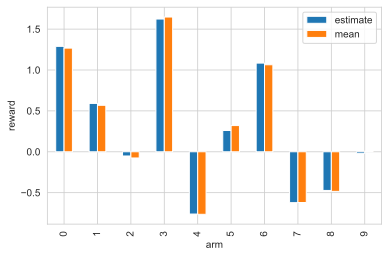

In [31]:
class Bandit:
    def __init__(self, num_arms: int) -> None:
        self.num_arms : int = num_arms
        self.means : NDArray[float] = np.random.normal(loc=0.0, scale=1.0, size=self.num_arms)

    def select(self, arm: int) -> float:
        reward : float = np.random.normal(loc=self.means[arm], scale=1.0)
        return reward


def estimate_means(bandit: Bandit, steps: int) -> List[float]:
    rewards : Dict[int, List[float]] = {arm: [] for arm in range(bandit.num_arms)}
    for _ in range(steps):
        arm : int = np.random.randint(bandit.num_arms)
        reward : float = bandit.select(arm=arm)
        rewards[arm].append(reward)
    averages : List[float] = [sum(rewards[arm]) / len(rewards[arm]) for arm in range(bandit.num_arms)]
    return averages


bandit : Bandit = Bandit(num_arms=10)
estimates : List[float] = estimate_means(bandit=bandit, steps=10000)

df : pd.DataFrame = pd.DataFrame({
    'estimate': estimates,
    'mean': bandit.means})
display(df)
df.plot(kind='bar', xlabel='arm', ylabel='reward')

## 活用と探索

,ε=1.0,ε=0.5,ε=0.1
0,0.710928,0.159568,-0.551073
1,1.117314,1.811772,-1.747556
2,2.934995,1.502836,-0.510373
3,2.211971,2.223093,-0.171402
4,0.650585,0.217988,-1.504994
...,...,...,...
495,25.638557,170.319929,224.448207
496,27.776887,169.325362,224.752106
497,27.314564,171.499856,224.409868
498,28.363456,172.420662,225.124639


<AxesSubplot:xlabel='step', ylabel='total rewards'>

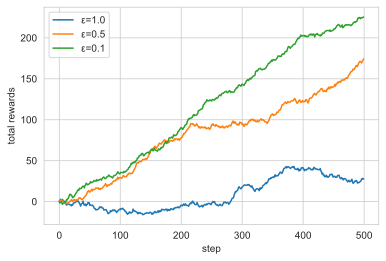

In [34]:
def get_action(means: List[float], epsilon: float) -> int:
    if np.random.random() < epsilon:
        return np.random.randint(len(means))
    else:
        return np.argmax(means)


def episode(bandit: Bandit, epsilon: float, steps: int) -> NDArray[float]:
    rewards : List[float] = [0] * steps
    means : List[float] = [0] * bandit.num_arms
    counts : List[int] = [0] * bandit.num_arms

    for step in range(steps):
        arm : int = get_action(means=means, epsilon=epsilon)
        reward : float = bandit.select(arm=arm)
        rewards[step] = reward
        counts[arm] += 1
        means[arm] += (reward - means[arm]) / counts[arm]
        
    return np.cumsum(rewards)


bandit = Bandit(num_arms=10)
rewards : Dict[str, NDArray[float]] = {f'ε={epsilon}': episode(bandit, epsilon, 500) for epsilon in [1.0, 0.5, 0.1]}

df : pd.DataFrame = pd.DataFrame(rewards)
display(df)

df.plot(xlabel='step', ylabel='total rewards')

## ハイパーパラメータチューニング

,ε=0.0,ε=0.1,ε=0.2,ε=0.3,ε=0.4,ε=0.5,ε=0.6,ε=0.7,ε=0.8,ε=0.9,ε=1.0
0,350.841685,818.438276,270.356894,954.821142,512.386153,151.215916,524.230548,169.618807,78.142401,4.571075,-89.670509
1,677.227063,292.296872,189.997193,749.998313,465.615169,478.701248,22.632922,49.810920,319.403409,-80.558203,221.565651
2,673.411269,791.711312,859.804859,584.453690,604.718566,365.634114,339.902144,242.982387,151.460728,244.898277,-75.055807
3,223.952290,634.827916,324.227118,560.958721,247.622082,186.866987,555.154355,253.906110,261.118559,15.192287,-102.578856
4,563.816510,918.331851,478.398388,397.076403,626.430781,330.690942,274.828742,606.865376,5.340961,584.059039,-211.011800
...,...,...,...,...,...,...,...,...,...,...,...
495,890.762570,481.295225,462.835631,517.908562,543.756935,250.360107,367.648765,138.557135,9.111749,241.257048,-7.643943
496,514.384552,958.546413,444.407169,399.061965,294.195069,154.135228,111.565086,216.174834,17.442750,18.468013,208.381223
497,307.902209,872.843140,213.670668,953.555059,727.445975,780.603294,386.899909,182.624347,2.210716,-185.549823,338.998851
498,1111.334127,558.170362,845.916753,559.039653,409.871564,191.171026,302.407501,494.745538,202.591014,15.778020,208.654719


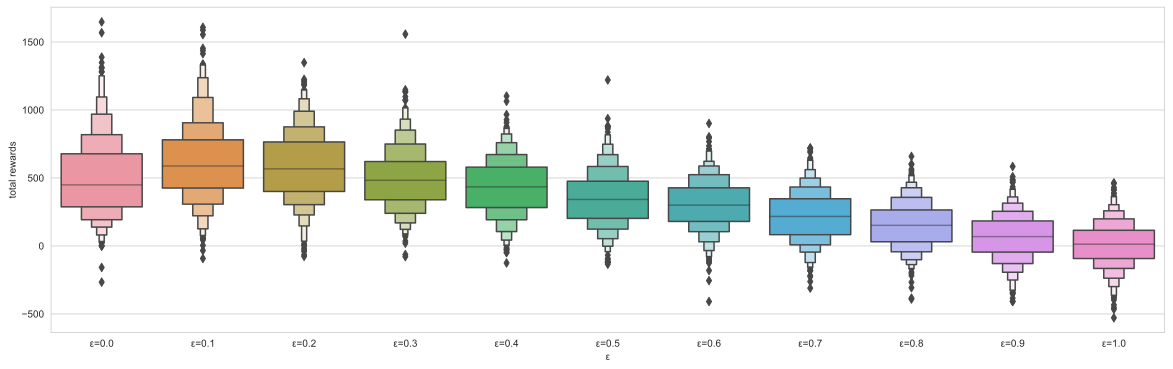

In [44]:
def hypertune(epsilons: List[float], num_samples: int) -> None:
    rewards : Dict[str, List[float]] = {}
    for epsilon in epsilons:
        scores : List[float] = [episode(Bandit(10), epsilon, 500)[-1] for _ in range(num_samples)]
        rewards[f'ε={epsilon:.1f}'] = scores

    df : pd.DataFrame = pd.DataFrame(rewards)
    display(df)
    plt.figure(figsize=(20, 6))
    sns.boxenplot(data=df)
    plt.xlabel('ε')
    plt.ylabel('total rewards')


hypertune(epsilons=np.linspace(0, 1.0, 11), num_samples=500)